In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
#constants

HBM = 7.6359  #eV
E2 = 14.409  #eV
a0 = 0.539 #Angstrom
alpha = 2*a0



In [8]:
def aeq(a,S):
    return a0/(1+ np.exp(-S/a))-a


#returns the value of a by solving the transcedental equation

def solvea(S,n=100):
    
    l,m=0.1,1 #Angstrom
    
    for i in range(n):
        
        fl=aeq(l,S)
        fm=aeq(m,S)
        
        
        p=(l+m)/2
        
        fp=aeq(p,S)
        
        if fl*fm<0:
            
            if fl*fp<0:
                m=p
            else:
                fp*fm<0
                l=p
        else:
               break

    return p

In [9]:
def distance(x1,y1,z1):
    
    #function to get the distances
    
    return np.sqrt(x1**2 +y1**2 +z1**2)



def R12(r1,r2):
    #euclidean distance
    x1 = r1[0];
    y1 = r1[1];
    z1 = r1[2];
    
    x2 = r2[0];
    y2 = r2[1];
    z2 = r2[2];
    
    return distance(x1-x2,y1-y2,z1-z2)

def Rl(r,S):
    x = r[0];
    y = r[1];
    z = r[2];
    
    return distance(x,y,z+S/2)

def Rr(r,S):
    x = r[0];
    y = r[1];
    z = r[2];
    
    return distance(x,y,z-S/2)
    
    

In [10]:
#functions and stuffs

def chi(r,a):
    return np.exp(-r/a)

def FDchi(r,a):
    return -chi(r,a)/a

def SDchi(r,a):
    return chi(r,a)/(a**2)

def lapchi(r,a):
    return SDchi(r,a)+2*FDchi(r,a)/r

def F(r,alpha,beta):
    return np.exp(r/(alpha*(1+beta*r)))

def FD(r,alpha,beta):
    return F(r,alpha,beta)/(alpha*(1+beta*r)**2)

def SD(r,alpha,beta):
    return ((FD(r,alpha,beta)**2)/F(r,alpha,beta)) - 2*beta*F(r,alpha,beta)/(alpha*(1+beta)**3)

def LapF(r,alpha,beta):
    return SD(r,alpha,beta)


In [11]:
def Phi(r1,r2,beta,S):
    
    alpha = 2*a0;
    a = solvea(S)
    
    r12=R12(r1,r2)
    rL1=Rl(r1,S)
    rL2=Rl(r2,S)
    rR1=Rr(r1,S)
    rR2=Rr(r2,S)
    
    
    phi1 = np.exp(-rL1/a) + np.exp(-rR1/a);
    phi2 = np.exp(-rL2/a) + np.exp(-rR2/a);
    
    
    f = np.exp(r12/(alpha*(1+beta*r12)));
    
    phi = phi1*phi2*f;
    
    return phi;

In [12]:
#MCMC

def MCMCrun(r1,r2,step,beta,S):
    
    "Takes Input in rx,ry,rz form"
    x1 = r1[0];
    y1 = r1[1];
    z1 = r1[2];
    
    x2 = r2[0];
    y2 = r2[1];
    z2 = r2[2];
    
    change1 = step*(2*np.random.rand()-1)
    
    change2 = step*(2*np.random.rand()-1)
    
    rt1 = [x1+change1,y1+change1,z1+change1]
    
    rt2 = [x2+change2,y2+change2,z2+change2]   
    
    eta = np.random.uniform(0,1);
    
    
    #print(rt1,r1)
    
    R = wavefunction(rt1,rt2,beta,S)/wavefunction(r1,r2,beta,S);
   
    #print(R)
    #use acceptance ratio to evaluate efficiency
        
    if R>eta:
        rnew1 = rt1;
        rnew2 = rt2;
        acc = 1
    else:
        rnew1 = r1;
        rnew2 = r2;
        acc = 0
        
    return rnew1,rnew2,acc

In [13]:
#Weight

def wavefunction(r1,r2,beta,S):
    
    alpha = 2*a0;
    a = solvea(S)
    
    r12=R12(r1,r2)
    rL1=Rl(r1,S)
    rL2=Rl(r2,S)
    rR1=Rr(r1,S)
    rR2=Rr(r2,S)
    
    
    phi1 = np.exp(-rL1/a) + np.exp(-rR1/a);
    phi2 = np.exp(-rL2/a) + np.exp(-rR2/a);
    
    
    f = np.exp(r12/(alpha*(1+beta*r12)));
    
    phi = phi1*phi2*f;
    
    return phi**2;


In [14]:
#local energy

def epsilon(r1,r2,beta,S):
    
    a = solvea(S)
    
    x1 = r1[0];
    y1 = r1[1];
    z1 = r1[2];
    
    x2 = r2[0];
    y2 = r2[1];
    z2 = r2[2];
    
    R1R =  Rr(r1,S)
    R1L =  Rl(r1,S)
    R2R =  Rr(r1,S)
    R2L =  Rl(r1,S)
    
    r12 = R12(r1,r2)
    #calculate dot products with R12
    R12DR1 = x1*(x1-x2)+y1*(y1-y2)+z1*(z1-z2) 
    SR12Z = S*(z1-z2)/2
    
    
    DOTR1L = R12DR1+SR12Z #Dot product with r12
    DOTR1R = R12DR1-SR12Z
    DOTR2L = DOTR1L-r12**2
    DOTR2R = DOTR1R-r12**2
    DOTR1L = DOTR1L/r12/R1L

    DOTR2L = DOTR2L/r12/R2L #Unit vector of above dot products
    DOTR1R = DOTR1R/r12/R1R
    DOTR2R = DOTR2R/r12/R2R

   
    
    CHI1 = chi(R1R,S)+chi(R1L,S)
    CHI2 = chi(R2R,S)+chi(R2L,S)
    f=F(r12,alpha,beta)
    
    
    EECORR = 2*LapF(r12,alpha,beta)/f
    ONEE1 = (lapchi(R1L,a)+lapchi(R1R,a))/CHI1 #electron one
    ONEE2 = (lapchi(R2L,a)+lapchi(R2R,a))/CHI2 #electron two
    
    
    CROSS1 = (FDchi(R1L,a)*DOTR1L+FDchi(R1R,a)*DOTR1R)/CHI1 #cross terms
    CROSS2 = (FDchi(R2L,a)*DOTR2L+FDchi(R2R,a)*DOTR2R)/CHI2
    CROSS = 2*FD(r12,alpha,beta)*(CROSS1-CROSS2)/f

    
    TPOP = -HBM*(EECORR+ONEE1+ONEE2+CROSS)/2 #kinetic
    VPOP = -E2*(1./R1L + 1./R1R + 1./R2L + 1./R2R - 1./r12) #potential
    ELOCAL=TPOP+VPOP
    
    return ELOCAL
    

In [15]:
def INTCFG(beta,S): #generates the intial confihutattion
    
    config1 = np.zeros(Ncoord)
    config2 = np.zeros(Ncoord)
    
    for i in range(Ncoord):
        config1[i] = a0*(np.random.rand()-0.5)
        config2[i] = a0*(np.random.rand()-0.5)
    
    config1[Ncoord-1] = config1[Ncoord-1]+ S/2
    config2[Ncoord-1] = config2[Ncoord-1]- S/2
    
    W = wavefunction(config1,config2,beta,S)
    
    return config1,config2,W

In [16]:
def INTENS(beta,S,NENSEM):
    #generate the ENSMBL at t-0 for PIMC
    x1,x2,w = INTCFG(beta,S)
    step = a0
    
    Ensem1 = np.zeros((NENSEM,3))
    Ensem2 = np.zeros((NENSEM,3))
    Waight = np.zeros(NENSEM)
    
    for i in range(20):
        x1,x2,acc = MCMCrun(x1,x2,step,beta,S)
        
    for i in range(10*NENSEM):
        xn1,xn2,acc = MCMCrun(x1,x2,step,beta,S)
        
        if(i%10 == 0):
            IENSEM = i/10
            for j in range(Ncoord):
                Ensem1[int(IENSEM),j] = xn1[j]
                Ensem2[int(IENSEM),j] = xn2[j]
            Waight[int(IENSEM)] = 1
    
    return Ensem1,Ensem2,Waight
    
    

In [17]:
def tstep(ensembl1,ensembl2,Weight,beta,S,NENSEM,DT):
    
    Ebar = 0;
    Wbar = 0;
    Ncord = 3
    
    HBMDT = HBM*DT;
    SQHBDT = np.sqrt(HBMDT)
    
    for i in range(NENSEM):
        
        config1 = ensembl1[i]
        config2 = ensembl2[i]
            
        shift1,shift2 = DRIFT(config1,config2,beta,S,DT);
        
        for k in range(Ncord):
            config1[k] = config1[k] + np.random.standard_normal()*SQHBDT + shift1[k]
            config2[k] = config2[k] + np.random.standard_normal()*SQHBDT + shift2[k]
            
        epsiln = epsilon(config1,config2,beta,S)
        
        Weight[i] = Weight[i]*np.exp(-epsiln*DT)
        Ebar = Ebar + Weight[i]*epsiln
        Wbar = Wbar + Weight[i]
        
    
        
        ensembl1[i] = config1
        ensembl2[i] = config2
        
    
        
    Epsiln = Ebar/Wbar
    Norm = NENSEM/Wbar
    
    for m in range(NENSEM):
        Weight[m] = Norm*Weight[m]
        
    return ensembl1,ensembl2,Weight,Epsiln

In [28]:
def DRIFT(r1,r2,beta,S,DT):
    
    alpha = 2*a0;
    a = solvea(S)
    
    r12=R12(r1,r2)
    rL1=Rl(r1,S)
    rL2=Rl(r2,S)
    rR1=Rr(r1,S)
    rR2=Rr(r2,S)
    
    CHI1 = chi(rR1,S)+chi(rL1,S)
    CHI2 = chi(rR2,S)+chi(rL2,S)
    f=F(r12,alpha,beta)
    
    
    HBMDT = HBM*DT
    FACTA = HBMDT*(FDchi(rL1,a)/rL1 + FDchi(rR1,a)/rR1)/CHI1
    FACTB = HBMDT*(FDchi(rL1,a)/rL1 - FDchi(rR1,a)/rR1)/CHI1
    FACTE = HBMDT*FD(r12,alpha,beta)/f/r12
    
    x1 = r1[0];
    y1 = r1[1];
    z1 = r1[2];
    
    x2 = r2[0];
    y2 = r2[1];
    z2 = r2[2];
    
    SHIFT1 = np.zeros(Ncoord);
    SHIFT2 = np.zeros(Ncoord);
    
    SHIFT1[0] = FACTA*x1+FACTE*(x1-x2)
    SHIFT1[1] = FACTA*y1+FACTE*(y1-y2)
    SHIFT1[2] = FACTA*z1+FACTE*(z1-z2)+FACTB*S/2
    
    FACTA = HBMDT*(FDchi(rL2,a)/rL1 + FDchi(rR2,a)/rR1)/CHI1
    FACTB = HBMDT*(FDchi(rL2,a)/rL1 - FDchi(rR2,a)/rR1)/CHI1
    
    SHIFT2[0] = FACTA*x2+FACTE*(x1-x2)
    SHIFT2[1] = FACTA*y2+FACTE*(y1-y2)
    SHIFT2[2] = FACTA*z2+FACTE*(z1-z2)+FACTB*S/2
    
    return SHIFT1,SHIFT2

In [19]:
#MCMC

def METROP(r1,r2,step,beta,S):
    
    "Takes Input in rx,ry,rz form"
    x1 = r1[0];
    y1 = r1[1];
    z1 = r1[2];
    
    x2 = r2[0];
    y2 = r2[1];
    z2 = r2[2];
    
    change1 = step*(np.random.rand()-0.5)
    
    change2 = step*(np.random.rand()-0.5)
    
    rt1 = [x1+change1,y1+change1,z1+change1]
    
    rt2 = [x2+change2,y2+change2,z2+change2]   
    
    eta = np.random.uniform(0,1);
    
    
    #print(rt1,r1)
    
    R = Weight(rt1,rt2,beta,S)/Weight(r1,r2,beta,S);
   
    #print(R)
    #use acceptance ratio to evaluate efficiency
        
    if R>eta:
        rnew1 = rt1;
        rnew2 = rt2;
        acc = 1
    else:
        rnew1 = r1;
        rnew2 = r2;
        acc = 0
    
    weight = Weight(rnew1,rnew2,beta,S)
    return rnew1,rnew2,acc,weight

In [20]:
#Wavefunction

def Weight(r1,r2,beta,S):
    
    alpha = 2*a0;
    a = solvea(S)
    
    r12=R12(r1,r2)
    rL1=Rl(r1,S)
    rL2=Rl(r2,S)
    rR1=Rr(r1,S)
    rR2=Rr(r2,S)
    
    
    phi1 = np.exp(-rL1/a) + np.exp(-rR1/a);
    phi2 = np.exp(-rL2/a) + np.exp(-rR2/a);
    
   
    f = np.exp(r12/(alpha*(1+beta*r12)));
    
    phi = phi1*phi2*f;
    
    return phi**2;

In [55]:
Nfreq = 5
Nsmpl = 100
Ncoord = 3
Nstep = Nfreq*Nsmpl

wight = np.zeros(Nstep)
Energy = np.zeros(Nsmpl)
Ensembl1=np.zeros((Nstep,3))
Ensembl2=np.zeros((Nstep,3))


def var_run(beta,S):

    delta = a0

    r1,r2,W1 = INTCFG(beta,S)

    Ntherm = 50
    a = 0
    for i in range(Ntherm):
        r1,r2,acc,W1 = METROP(r1,r2,delta,beta,S)
        a = a+acc
    
    
    Ensembl1[0] = r1
    Ensembl2[0] = r1
    wight[0] = W1
    Energy[0] = epsilon(r1,r2,beta,S)

    A = 0

    for i in range(1,Nstep):
    
        r1,r2,acc,W1 = METROP(r1,r2,delta,beta,S)
        wight[i] = W1
        A = A + acc
        Ensembl1[i] = r1
        Ensembl2[i] = r2
    
        if(i%Nfreq==0):
            j = i/Nfreq
            Energy[int(j)] = epsilon(r1,r2,beta,S)
    
    print("Acceptance Ratio = {}".format(A/Nstep))
    
    return Energy

In [58]:
S = 0.5
b = np.linspace(0,3,10)
Ent = []

for bt in b:
    En = var_run(bt,S)
    emean = np.mean(En)
    Ent.append(emean)
    
indx = np.where(Ent==np.min(Ent))
beta = b[indx]




Acceptance Ratio = 0.636
Acceptance Ratio = 0.664
Acceptance Ratio = 0.63
Acceptance Ratio = 0.65
Acceptance Ratio = 0.59
Acceptance Ratio = 0.644
Acceptance Ratio = 0.57
Acceptance Ratio = 0.604
Acceptance Ratio = 0.612
Acceptance Ratio = 0.594


In [42]:
E = var_run(0.2,0.5)

Acceptance Ratio = 0.674


In [61]:
beta = 2
S = 0.5
DT = 0.001

con1,con2,W1 = INTENS(0.2,0.5,Nstep)

Ntherm = 50

for i in range(Ntherm):
    con1,con2,W1,eps = tstep(con1,con2,W1,beta,S,Nstep,DT)

Ensembl1 = con1
Ensembl2 = con2
wight = W1
Energy[0] = eps

    
for i in range(1,Nstep):
    
    con1,con2,W1,eps = tstep(con1,con2,W1,beta,S,Nstep,DT)
    wight = W1
    Ensembl1 = con1
    Ensembl2 = con2
    
    if(i%Nfreq==0):
        j = i/Nfreq
        Energy[int(j)] = eps
    

In [101]:
def Energyvals(Energy,S):
    
    c = []
    Eavg = np.mean(Energy)
    Eavg2 = np.mean(Energy**2)
    ABOHR = HBM/E2
    N = np.size(Energy)
    
    for k in range(N):
        fk = 0
        for i in range(N-k):
            fk = fk + Energy[i]*Energy[i+k]
        fk = fk/(N-k)
        ck = (fk-Eavg**2)/(Eavg2-Eavg**2)
        c.append(ck)
    
    print(Eavg)
    U = Eavg + E2/S + E2/ABOHR
    
    return c,U

In [102]:
F,U = Energyvals(E,0.5)

-71.95235452388366


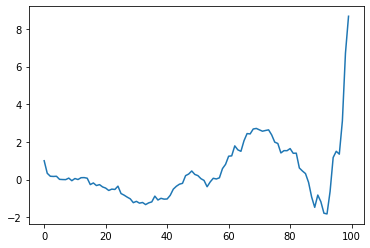

In [103]:
plt.plot(F)